# Identication of putative contaminant taxa

In [2]:
setwd("/mnt/c/Users/Cedric/Desktop/git_repos/blood_microbiome")
require(foreach)
require(tidyverse)
require(ggplot2)
require(data.table)
require(compositions)
require(doParallel)
require(VennDiagram)
registerDoParallel(cores=8)

Loading required package: foreach

Loading required package: tidyverse

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate() masks foreach::accumulate()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ purrr::when()       masks foreach::when()

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: compos

### Data pre-processing functions

In [3]:
load_data <- function(file_path) {
    df <- as.data.frame(fread(file_path)) %>%
        separate(sample, into = c(NA, "npm_research_id"), sep = "\\.")
    return(df)
}


load_metadata <- function(file_path, df) {
    meta <- fread(file_path, na.strings=c("", NA))
    meta <- meta %>% 
        filter(npm_research_id %in% df$npm_research_id) %>%
        select(-removal_requested_by_supplier) %>%
        replace(is.na(.), "unknown")
    return(meta)
}


subset_metadata <- function(meta, n_subset) {
    meta <- as.data.frame(meta)
    cohorts <- unique(meta$site_supplying_sample)
    subset_vec <- c()

    for (i in cohorts) {
        ids <- meta$npm_research_id[meta$site_supplying_sample == i]
        
        if (length(ids) > n_subset) {
            subset_ids <- sample(ids, n_subset)
            subset_vec <- c(subset_vec, subset_ids)
        } else {
            subset_vec <- c(subset_vec, ids)
        }
    }

    meta_sub <- meta %>%
      filter(npm_research_id %in% subset_vec) 
    return(meta_sub)
}


retrieve_rows_from_meta <- function(df, meta) {
    return(df %>% filter(npm_research_id %in% meta$npm_research_id)) 
}


remove_cols <- function(df, col_to_exclude) {
    return(df %>% select(-all_of(col_to_exclude)))
}


remove_low_prev_taxa <- function(df, frac_presence, read_threshold) {
    n_original <- ncol(df[, colnames(df) != "npm_research_id"])
    PA_df <- apply(df[, 2:ncol(df)], 2, function(x) {ifelse(x > read_threshold, T, F)})
    frac_df <- apply(PA_df, 2, function(x) {sum(x) / nrow(PA_df)})
    to_keep <- names(frac_df[frac_df > frac_presence])
    to_keep <- c("npm_research_id", to_keep)
    n_new <- length(to_keep) - 1
    print(str_glue("{n_new} / {n_original} taxa are present in {frac_presence} of samples"))
    return(df %>% select(all_of(to_keep)))
}


otu_to_RA <- function(df) {
    mat <- as.matrix(df[, colnames(df) != "npm_research_id"])
    RA_df <- as.data.frame(mat / rowSums(mat))
    RA_df <- add_column(RA_df, df$npm_research_id, .before = 1)
    colnames(RA_df)[1] <- "npm_research_id"
    
    return(RA_df)
}


RA_to_clr <- function(df) {
    mat <- df_filt[, colnames(df_filt) != "npm_research_id"]
    clr_df <- clr(mat)
    return(cbind(data.frame(npm_research_id = df$npm_research_id), as.data.frame(clr_df, check.names = F)))
}


get_metadata_plots <- function(meta, meta_cols) {
    meta <- as.matrix(meta)
    meta <- as_tibble(meta, rownames = "sample")

    plots <- list()
    
    for (column in meta_cols) {
        plt <- meta %>%
            mutate(across(everything(), as.character)) %>%
            select(all_of(column)) %>%
            group_by_at(column) %>%
            summarise(n = n()) %>%
            ggplot(aes_string(x = column, y = "n", fill = column)) +
                geom_bar(stat = "identity") +
                theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
                geom_text(aes_string(label = "n"))
        plots[[column]] <- plt
    }
    
    return(plots)
}


get_meta_cols <- function(meta) {
    meta_cols <- colnames(meta)[grep("kit|flow_cell|instrument_id|site_supplying", colnames(meta))]
    to_exclude <- c("library_prep_kit", "hiseq_xtm_flow_cell_v2_5_id")
    meta_cols <- meta_cols[!(meta_cols %in% to_exclude)]
    return(meta_cols)
}


print_group_freqs <- function(meta, meta_cols) {
    for (col in meta_cols) {
        tmp <- tibble(data.frame(meta)) %>%
            group_by(get(col)) %>%
            summarise(n = n())
        print(col)
        print(tmp)
    }
}


get_batch_prevalence <- function(x) {sum(x) / length(x)}


remove_low_read_samples <- function(df) {
    to_retain <- fread("data/samples_above_10_reads.txt")$npm_research_id
    return(df %>% filter(npm_research_id %in% to_retain))
}


remove_low_sample_levels <- function(dat, metadat, column, min_samples) {
    # Remove levels with < x samples
    tmp <- tibble(data.frame(metadat)) %>%
            group_by(get(column)) %>%
            summarise(n = n())

    # Vector of group levels to keep
    to_keep <- tmp[tmp$n >= min_samples, "get(column)"]$`get(column)`
    to_keep <- to_keep[to_keep != "Unknown"]
    n_levels <- length(to_keep)

    if (n_levels < 2) {
        print(str_glue("After pruning, {column} has < 2 levels"))
    } else {
        print(str_glue("After pruning, {column} has {n_levels} levels"))
    }

    # Remove rows in metadata
    metadat_filt <- metadat %>% filter(get(column) %in% to_keep)

    # Retrieve rows
    dat_filt <- retrieve_rows_from_meta(dat, metadat_filt)
    metadat_filt <- metadat_filt %>% filter(npm_research_id %in% dat_filt$npm_research_id)

    return(list(dat_filt = dat_filt, metadat_filt = metadat_filt))
}


remove_empty_rows <- function(df) {
    mat <- as.matrix(df[, colnames(df) != "npm_research_id"])
    row_sums <- rowSums(mat)
    df_filt <- df[row_sums != 0, ]
    nrow(df_filt)

    n_original <- nrow(df)
    n_removed <- n_original - nrow(df_filt)
    
    print(str_glue("{n_removed}/{n_original} samples removed due to having no reads of interest"))
    
    return(df_filt)
}

#### Params

In [4]:
min_samples <- 10
n_subset <- 9999
human <- "Homo sapiens"
rank <- "S"
n <- 9999

max_prev_t <- 0.25
fold_diff_t <- 2

#### Load and parse data

In [5]:
to_retain <- fread("data/samples_above_100_microbial_reads.txt")$npm_research_id
df <- load_data(str_glue("data/temp_files_{n_subset}/07_abundance_matrix/abundance_matrix.subset_{n_subset}.{rank}.tsv")) %>% 
    filter(npm_research_id %in% to_retain)

# Get non-contaminants/contaminants
nc <- read.csv(str_glue("results/decontamination/diff_prev_V3/noncontaminants.RA0.01.read_threshold10.max_prev{max_prev_t}.fold_diff{fold_diff_t}.txt"))$taxa
contams <- read.csv(str_glue("results/decontamination/diff_prev_V3/contaminants.RA0.01.read_threshold10.max_prev{max_prev_t}.fold_diff{fold_diff_t}.txt"))$taxa

df_filt <- df %>% select(all_of(c("npm_research_id", nc, contams)))
df_filt <- otu_to_RA(df_filt)
df_filt <- RA_to_clr(df_filt)
df_filt

npm_research_id,Paraburkholderia xenovorans,Paraburkholderia hospita,Burkholderia cepacia,Burkholderia metallica,Burkholderia contaminans,Burkholderia gladioli,Burkholderia sp. OLGA172,Massilia sp. WG5,Bradyrhizobium sp. WSM471,⋯,Massilia oculi,Microbacterium chocolatum,Methylobacterium phyllosphaerae,Acinetobacter johnsonii,Rhodococcus erythropolis,Sphingomonas sp. NIC1,Herbaspirillum rubrisubalbicans,Microbacterium sp. 10M-3C3,Herbaspirillum seropedicae,Bradyrhizobium sp. ORS 285
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WHB669,-0.1317171,-0.13171713,-0.1317171,-0.82486431,-0.82486431,-0.82486431,-0.8248643,-0.82486431,-0.8248643,⋯,0.00000000,0.0000000,0.0000000,0.000000,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,0.00000000
WHB8678,0.0000000,0.00000000,-0.1677803,0.00000000,0.30222335,-1.08407102,0.0000000,-0.16778028,-0.3909238,⋯,-1.08407102,-0.3909238,0.0000000,0.000000,0.00000000,3.04306337,-1.7772182,-0.3909238,0.0000000,0.52536690
WHH7080,0.0000000,0.00000000,0.0000000,0.00000000,0.00000000,-0.10780699,-1.4941014,-0.39548906,0.0000000,⋯,0.00000000,-0.8009542,2.1947781,2.219471,2.37709966,0.45180880,0.9037939,0.0000000,1.5504211,-1.49410135
WHB4818,0.0000000,0.00000000,0.0000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.0000000,⋯,0.00000000,0.0000000,0.0000000,0.000000,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,0.00000000
WHB9470,0.0000000,-1.65659597,-0.9634488,-1.65659597,-1.65659597,0.42284558,0.0000000,1.11599276,0.0000000,⋯,-0.96344879,0.8283107,0.9083534,3.226206,-0.04715805,0.42284558,2.0569761,1.7446014,1.8987521,-1.65659597
WHB4637,0.0000000,0.00000000,0.0000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.0000000,⋯,0.00000000,0.0000000,0.0000000,0.000000,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,0.00000000
WHB3974,-1.1282788,-0.02966647,-0.4351316,0.00000000,-1.12827876,0.25801560,0.0000000,-0.43513158,0.0000000,⋯,-1.12827876,0.0000000,2.8420132,0.000000,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,1.35662789
WHB7065,0.0000000,0.00000000,0.0000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.2477185,⋯,-0.85089375,0.0000000,0.0000000,0.000000,0.00000000,0.24771854,0.0000000,0.0000000,0.0000000,0.24771854
WHB8830,0.0000000,0.00000000,-1.4470795,0.00000000,0.00000000,0.00000000,0.0000000,0.49883068,0.0000000,⋯,0.00000000,1.2609707,0.6323621,2.541905,2.04942810,0.85550563,1.8487574,1.9541179,1.4973595,-1.44707947


### Correlation filter after Diff. Prev. + Diff. Abn.

In [5]:
corr_decontam <- function(df, non_contaminants, contaminants) {
    nc_list <- foreach (non_contaminant_taxon = non_contaminants) %dopar% {
        morsel <- tibble()
        for (contaminant_taxon in contaminants) {
            spearman_test <- cor.test(df[ ,contaminant_taxon], df[, non_contaminant_taxon])
            rho <- spearman_test$estimate
            print(str_glue("{non_contaminant_taxon} has correlation of {rho} with {contaminant_taxon}"))
            morsel <- morsel %>% bind_rows(tibble(non_contaminant_taxon = non_contaminant_taxon, 
                                           contaminant_taxon = contaminant_taxon,
                                           rho = rho))
        }

        return(morsel)
    }

    corr_df <- bind_rows(nc_list)  
    return(corr_df)
}


parse_corr_results <- function(corr_df, nc, corr_t) {
    parsed <- corr_res %>%
    mutate(above_corr = ifelse(rho > corr_t, T, F)) %>%
    group_by(non_contaminant_taxon) %>%
    summarise(n_corr = sum(above_corr))
    
    contaminants <- parsed %>%
        filter(n_corr > 0) %>%
        distinct(non_contaminant_taxon) %>%
        rename(contaminants = non_contaminant_taxon)
    
    non_contaminants <- parsed %>%
        filter(n_corr == 0) %>%
        distinct(non_contaminant_taxon)
    
    return(list(non_contaminants = non_contaminants, contaminants = contaminants))
}

In [6]:
corr_res <- corr_decontam(df_filt, nc, contams)
# fwrite(corr_res, str_glue("results/decontamination/correlation_decontamination/corr_results.min_samples{min_samples}.l{lq_p * 100}h{hq_p * 100}.csv"))
# corr_res <- fread("results/decontamination/correlation_decontamination/corr_results.min_samples{min_samples}.l{lq_p * 100}h{hq_p * 100}.csv")

### Choosing  correlation threshold

#### Case studies

In [7]:
corr_df <- corr_res %>%
    mutate(fill_color = case_when(rho <= 0 ~ "<0",
                     rho > 0 & rho <= 0.1 ~ "0-0.1",
                     rho > 0.1 & rho <= 0.2 ~ "0.1-0.2",
                     rho > 0.2 & rho <= 0.3 ~ "0.2-0.3",
                     rho > 0.3 & rho <= 0.5 ~  "0.3-0.5",
                     rho > 0.5 & rho <= 0.7 ~ "0.5-0.7",
                     rho > 0.7 ~ ">0.7")) %>%
    mutate(fill_color = factor(fill_color, levels = c("<0", "0-0.1", "0.1-0.2", "0.2-0.3", "0.3-0.5", "0.5-0.7", ">0.7")))

In [8]:
# taxon <- "Lactobacillus paragasseri"
# taxon_name <- gsub(" ", "_", taxon)

# corr_df %>% 
# filter(non_contaminant_taxon == taxon) %>%
#     ggplot(aes(x = rho, fill = fill_color)) +
#     geom_histogram(bins = 50) +
#     labs(x = "Spearman's rho (CLR)", "No. of contaminants", title = taxon) +
#     scale_fill_manual(values = c("#6699cc", "#ffffcc", "#f39b7fb2", "#e64b35b2", "#d11141"))

# ggsave(str_glue("results/decontamination/correlation_decontamination/{taxon_name}.min_samples{min_samples}.l{lq_p * 100}h{hq_p * 100}.png"))

In [9]:
# taxon <- "Moraxella osloensis"
# taxon_name <- gsub(" ", "_", taxon)
# corr_df %>% 
# filter(non_contaminant_taxon == taxon) %>%
#     ggplot(aes(x = rho, fill = fill_color)) +
#     geom_histogram(bins = 50) +
#     labs(x = "Spearman's rho (CLR)", "No. of contaminants", title = taxon) +
#     scale_fill_manual(values = c("#6699cc", "#ffffcc", "#f39b7fb2", "#e64b35b2", "#d11141"))

# # ggsave(str_glue("results/decontamination/correlation_decontamination/{taxon_name}.png"))

In [10]:
# corr_t <- 0.1
# parsed <- corr_df %>%
#     group_by(non_contaminant_taxon) %>%
#     mutate(above_corr = ifelse(rho > corr_t, T, F)) %>%
#     summarise(diff = sum(above_corr) / n_distinct(corr_df$contaminant_taxon))

# parsed %>%
#  ggplot(aes(x = diff)) +
#     geom_histogram(bins = 50) +
#     labs(x = str_glue("Prop. of NC-C correlations (rho > {corr_t})"), y = "No. of non-contaminants")

# # ggsave(str_glue("results/decontamination/correlation_decontamination/rho_histogram.min_samples{min_samples}.l{lq_p * 100}h{hq_p * 100}.png"))

#### Heatmap of correlations

In [11]:
plot_heatmap <- function(corr_df) {
    wide_df <- corr_df %>%
        pivot_wider(!fill_color, names_from = non_contaminant_taxon, values_from = rho) %>%
        column_to_rownames("contaminant_taxon")

    data <- scale(t(wide_df))
    ord_row <- hclust(dist(data, method = "euclidean"), method = "ward.D")$order

    data <- scale(wide_df)
    ord_col <- hclust(dist(data, method = "euclidean"), method = "ward.D")$order

    hm <- corr_df %>%
        mutate(non_contaminant_taxon = factor(non_contaminant_taxon, levels = colnames(wide_df)[ord_row]), 
               contaminant_taxon = factor(contaminant_taxon, levels = rownames(wide_df)[ord_col])) %>%
        ggplot(aes(x = non_contaminant_taxon, y = contaminant_taxon, fill = fill_color)) +
        geom_tile() +
        theme(axis.ticks.x = element_blank(),
              axis.text.x = element_blank(),
              axis.ticks.y = element_blank(),
              axis.text.y = element_blank()) +
        scale_fill_manual(values = c("#6699cc", "#ffffcc", "#f39b7fb2", "#e64b35b2", "#d11141", "darkred", "black")) +
        labs(x = "Non-contaminant species", y = "Contaminant species", fill = "Rho")

    return(hm)
}


#### Before correlation filter

Saving 6.67 x 6.67 in image



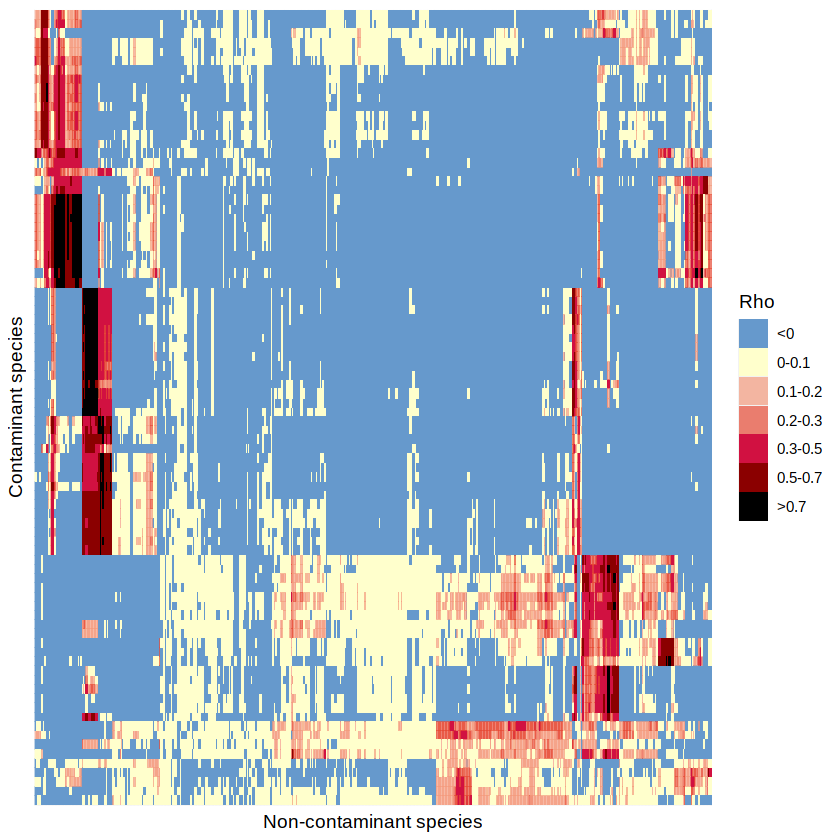

In [17]:
plot_heatmap(corr_df)
ggsave(str_glue("results/decontamination/correlation_decontamination/correlation_heatmap.diff_prev_V3.max_prev{max_prev_t}.fold_diff{fold_diff_t}.png"), dpi = 300)

In [15]:
corr_t <- 0.7
corr_parsed <- parse_corr_results(corr_res, nc, corr_t = corr_t)
corr_nc <- corr_parsed[["non_contaminants"]]
corr_c <- corr_parsed[["contaminants"]]

fwrite(corr_nc, 
       str_glue("results/decontamination/correlation_decontamination/nc.diff_prev_V3.RA0.01.read_threshold10.max_prev{max_prev_t}.fold_diff{fold_diff_t}.corr_t{corr_t}.S.n9999.txt"))
fwrite(corr_c, 
       str_glue("results/decontamination/correlation_decontamination/contam.diff_prev_V3.RA0.01.read_threshold10.max_prev{max_prev_t}.fold_diff{fold_diff_t}.corr_t{corr_t}.S.n9999.txt"))

print(length(corr_nc$non_contaminant_taxon))
print(length(corr_c$contaminants))

[1] 434
[1] 44


#### After removal

In [1]:
plot_heatmap(corr_df %>% filter(non_contaminant_taxon %in% corr_nc$non_contaminant_taxon))
ggsave(str_glue("results/decontamination/correlation_decontamination/correlation_heatmap.after_corr.diff_prev_V3.max_prev{max_prev_t}.fold_diff{fold_diff_t}.png"), dpi = 300)

ERROR: Error in plot_heatmap(corr_df %>% filter(non_contaminant_taxon %in% corr_nc$non_contaminant_taxon)): could not find function "plot_heatmap"


### Controls

In [16]:
pos_control <- read.csv("data/reported_controls/damgaard_2015_positive.txt")$positive_controls
torque_tenos <- colnames(df_filt)[grepl("torque teno", colnames(df_filt), ignore.case = T)]
herpes <- colnames(df_filt)[grepl("herpes", colnames(df_filt), ignore.case = T)]
pos_control <- c(pos_control, 
                 "Escherichia coli",
                 "Pasteurella multocida", 
                 "Bartonella henselae", "Bartonella clarridgeiae", 
                 "Enterococcus faecalis", "Cutibacterium acnes", "Staphylococcus epidermis", "Actinomyces viscosus",
                 "Streptococcus agalactiae",
                 "Yersinia enterocolitica",
                 "Leclercia adecarboxylata",
                 "Streptococcus pneumoniae",
                 torque_tenos,
                 herpes
                 )
neg_control1 <- read.csv("data/reported_controls/asmp_parsed_negative.txt")$taxa
neg_control2 <- read.csv("data/reported_controls/chng_2020_parsed_negative.txt")$taxa
neg_control3 <- read.csv("data/reported_controls/caregiver_parsed_negative.txt")$taxa

intersection <- Reduce(intersect, list(neg_control1, neg_control2, neg_control3))
union <- unique(c(neg_control1, neg_control2, neg_control3))

# At least 2 studies
all_neg <- table(c(neg_control1, neg_control2, neg_control3))
semi_union <- names(all_neg[all_neg >= 2])

pos_not_intersect <- pos_control[!(pos_control %in% intersection)]
pos_not_union <- pos_control[!(pos_control %in% union)]
pos_not_semi <- pos_control[!(pos_control %in% semi_union)]

print(length(intersection))
print(length(union))
print(length(semi_union))
print(length(pos_control))
print(length(pos_not_intersect))
print(length(pos_not_union))

[1] 8
[1] 320
[1] 53
[1] 51
[1] 50
[1] 39


In [17]:

venn_list1 <- list(nc = corr_nc$non_contaminant_taxon,
                  contam = corr_c$contaminants, 
                  pos_not_semi = pos_not_semi)

venn_list2 <- list(nc = corr_nc$non_contaminant_taxon,
                  contam = corr_c$contaminants, 
                  semi_union = semi_union)

# venn.diagram(venn_list1, 
#              filename = str_glue("results/decontamination/correlation_decontamination/corr_decontamination_results_pos_controls.png"),
# #              category.names = c("Identified non-contaminants", "Identified contaminants", "Found in blood"),
#              category.names = c("", "", ""),
#              print.mode = c("raw"),
#              fill = c("#999999", "#E69F00", "#66a182")
#              )

# venn.diagram(venn_list2, 
#              filename = str_glue("results/decontamination/correlation_decontamination/corr_decontamination_results_neg_controls.png"),
# #              category.names = c("Identified non-contaminants", "Identified contaminants", "Common contaminants (union)"),
#              category.names = c("", "", ""),
#              print.mode = c("raw"),
#              fill = c("#999999", "#E69F00", "#f8766d")
#              )

# filename = str_glue("results/decontamination/diff_prev_V3/decontamination_results_pos_controls.png"),

In [18]:
corr_nc$non_contaminant_taxon[corr_nc$non_contaminant_taxon %in% pos_control]

[1] "Actinomyces viscosus"     "Bacillus thuringiensis"  
 [3] "Cutibacterium acnes"      "Cutibacterium granulosum"
 [5] "Escherichia coli"         "Human alphaherpesvirus 2"
 [7] "Human betaherpesvirus 5"  "Human betaherpesvirus 6A"
 [9] "Human betaherpesvirus 6B" "Moraxella osloensis"     
[11] "Pasteurella multocida"    "Staphylococcus aureus"   
[13] "Staphylococcus warneri"   "Streptococcus agalactiae"
[15] "Streptococcus pneumoniae" "Torque teno mini virus 3"
[17] "Torque teno mini virus 7" "Torque teno virus"       
[19] "Torque teno virus 12"     "Torque teno virus 13"    
[21] "Torque teno virus 15"     "Torque teno virus 19"    
[23] "Torque teno virus 20"     "Torque teno virus 21"    
[25] "Torque teno virus 23"     "Torque teno virus 27"    
[27] "Torque teno virus 28"     "Torque teno virus 29"    
[29] "Torque teno virus 3"      "Torque teno virus 5"     
[31] "Torque teno virus 6"      "Torque teno virus 7"     
[33] "Torque teno virus 8"

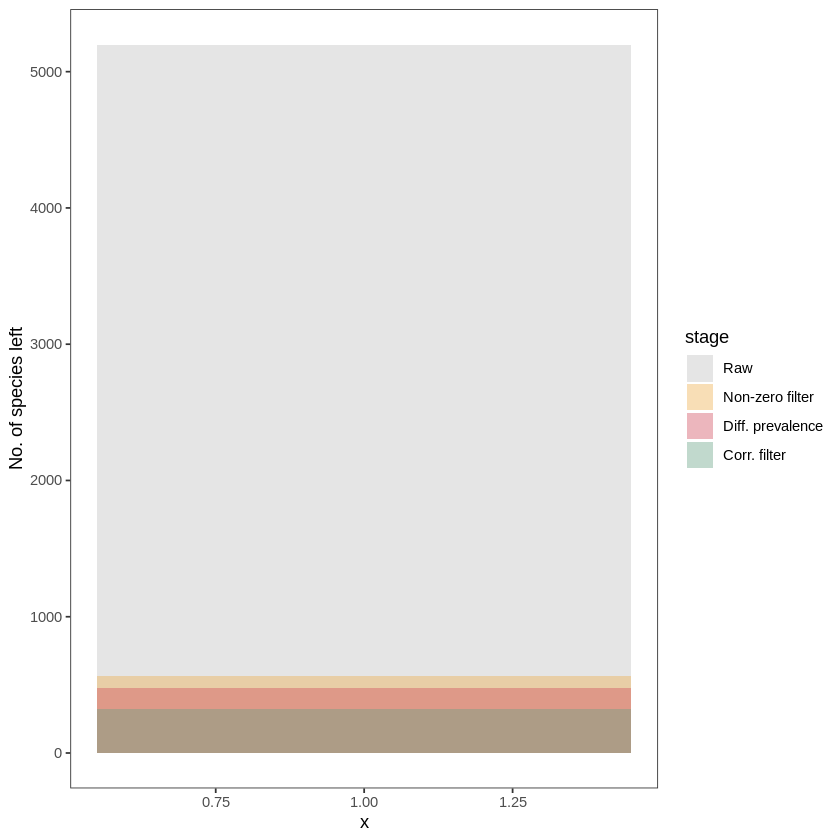

In [19]:
tibble(stage = c("Raw", "Non-zero filter", "Diff. prevalence", "Corr. filter"),
       n_species = c(ncol(df) - 3, ncol(df_filt) - 1, length(nc), length(corr_nc$non_contaminant_taxon))) %>%
    mutate(stage = factor(stage, levels = c("Raw", "Non-zero filter", "Diff. prevalence", "Corr. filter"))) %>%
    ggplot(aes(x = 1, y = n_species, fill = stage)) +
        theme_bw() +
        geom_bar(stat = "identity", position = "identity", alpha = 0.4) +
    scale_fill_manual(values = c("grey", "#edae49", "#d1495b", "#66a182")) +
    theme(panel.grid = element_blank()) +
    labs(y = "No. of species left")